# Snorkelを用いたデータのラベル付け

このノートブックでは、Snorkelを用いて、データをラベル付けする方法を紹介します。ここでの目標は、YouTubeのコメントがスパムか否かを分類するのに使えるデータセットを構築することです。Snorkelの使い方の詳細については、[公式のチュートリアル](https://github.com/snorkel-team/snorkel-tutorials)を参照してください。

<!--
This notebook has been adapted from the [spam example](https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb) of the [snorkel examples github](https://github.com/snorkel-team/snorkel-tutorials). Please visit the official snorkel tutorials [link](https://github.com/snorkel-team/snorkel-tutorials) for a more detailed and exhautive guide on how to use snorkel.<br>
This notebook demonstrates how to use snorkel for data labeling. Our goal here is to build a dataset which can be used to classify if a Youtube comment is Spam or Ham.
-->

## パッケージのインストール

In [1]:
!pip install  snorkel==0.9.7 treedlib==0.1.3 numbskull==0.1.1
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 153kB 12.5MB/s 
     |████████████████████████████████| 3.8MB 37.7MB/s 
     |████████████████████████████████| 1.8MB 28.6MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556427 sha256=84167059d0090a2e96bfee130160759ab6e8bec152d5341461fa3cacde931d7d
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: networkx 2.5.1
    Uninstalling networkx-2.5.1:
      Successfully uninstalled networkx-2.5.1
✔ Download and installation successful
You ca

## データセット

では、YouTubeのスパム分類データセットをUCI MLリポジトリから取得しましょう。データセットは以下のリンクから取得できます。

- [YouTube-Spam-Collection-v1.zip](http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip)

In [2]:
%cd /content/
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
!unzip YouTube-Spam-Collection-v1.zip
!ls
!rm -r __MACOSX

/content
--2021-07-13 00:55:12--  http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163567 (160K) [application/x-httpd-php]
Saving to: ‘YouTube-Spam-Collection-v1.zip’

YouTube-Spam-Collec 100%[===================>] 159.73K   241KB/s    in 0.7s    

2021-07-13 00:55:13 (241 KB/s) - ‘YouTube-Spam-Collection-v1.zip’ saved [163567/163567]

Archive:  YouTube-Spam-Collection-v1.zip
  inflating: Youtube01-Psy.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._Youtube01-Psy.csv  
  inflating: Youtube02-KatyPerry.csv  
  inflating: __MACOSX/._Youtube02-KatyPerry.csv  
  inflating: Youtube03-LMFAO.csv     
  inflating: __MACOSX/._Youtube03-LMFAO.csv  
  inflating: Youtube04-Eminem.csv    
  inflating: __MACOSX/._Youtube04-Eminem.csv  

次に、必要なリポジトリをクローンします。

In [3]:
!git clone https://github.com/snorkel-team/snorkel-tutorials.git

Cloning into 'snorkel-tutorials'...
remote: Enumerating objects: 1108, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 1108 (delta 17), reused 16 (delta 8), pack-reused 1059
Receiving objects: 100% (1108/1108), 3.53 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (732/732), done.


In [4]:
%cd /content/snorkel-tutorials/spam/

/content/snorkel-tutorials/spam


## パッケージのインポート

In [5]:
import re

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from snorkel.analysis import get_label_buckets
from snorkel.labeling import labeling_function, LFAnalysis, PandasLFApplier, LabelingFunction, filter_unlabeled_dataframe
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor
from snorkel.utils import probs_to_preds
from textblob import TextBlob

import utils
from utils import load_spam_dataset
%matplotlib inline

In [6]:
%cd /content/snorkel-tutorials/spam/
df_train, df_test = load_spam_dataset()
print("Train")
display(df_train.head())
print("Test")
df_test.head()

/content/snorkel-tutorials/spam
Train


,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1


Test


,author,date,text,label,video
27,‫حلم الشباب‬‎,2015-05-25T23:42:49.533000,Check out this video on YouTube:﻿,1,5
194,MOHAMED THASLEEM,2015-05-24T07:03:59.488000,super music﻿,0,5
277,AlabaGames,2015-05-22T00:31:43.922000,Subscribe my channel I RECORDING FIFA 15 GOAL...,1,5
132,Manish Ray,2015-05-23T08:55:07.512000,This song is so beauty,0,5
163,Sudheer Yadav,2015-05-28T10:28:25.133000,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,5


In [7]:
Y_test = df_test.label.values
Y_test[:5]

array([1, 0, 1, 0, 1])

データセットに関して、いくつか抑えておくべき点があります。

1. HAMはスパムでないコメントを表す
2. SPAMはスパムコメントを表す
3. ABSTAINは上記のどちらでもない

各値を以下のように設定します。

In [8]:
ABSTAIN = -1
HAM = 0
SPAM = 1

データをラベル付けするためのルールを作成するには、データに潜むパターンを見つける必要があります。そのため、以下ではデータセットからランダムに行を抽出して表示しています。この中からパターンを見つけてみましょう。

In [9]:
df_train[["author", "text", "video"]].sample(20, random_state=2020)

,author,text,video
240,Lucas Trigo,WHATS UP EVERYONE!? :-) I Trying To Showcase M...,1
211,Blaze Rod,when i see this back in 2015 i ask myself how ...,3
228,MasterRobotTV,http://www.twitch.tv/zxlightsoutxz﻿,1
207,Franklin Music,Very Nice !﻿,3
153,lebanonwarior1,Song name??﻿,1
8,yenis maría Rodríguez,2015 LIKEEE﻿,3
62,RapStarz Coleman,Subscribe To Mê Please Guys,4
54,Jd Hurst,Check out this video on YouTube:﻿,3
353,jefflynnejp,Check out this video on YouTube: ﻿,3
406,eliška žáková,CUTE :)﻿,3


ラベル付け関数を定義する際には、スパムメッセージのパターンに一致するものであれば何でも指定できます。ここでは、スパムコメントにはリンクが含まれることが多いことを利用して、httpというパターンを指定しています。

In [10]:
@labeling_function()
def lf_contains_link(x):
    # コメントに「http」が含まれるならラベルとしてSPAMを返す。それ以外ならABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN

「check」「check out」「http」「my channel」「subscribe」などの文字列をチェックするラベル付け関数を定義してみましょう。

In [11]:
@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

@labeling_function()
def my_channel(x):
  return SPAM if "my channel" in x.text.lower() else ABSTAIN

@labeling_function()
def if_subscribe(x):
  return SPAM if "subscribe" in x.text.lower() else ABSTAIN

**PandasLFApplier**を使うことで、pandasのデータフレームに対してラベル付け関数を適用できます。また、ラベル付け関数はテキスト以外のカラムに対しても適用できます。なお、**PandasLFApplier**では、ラベル付け関数は**pandas.DataFrame.apply**を使って実行されます。この方法だと、巨大なデータフレームに対しては遅くなる場合があります。そのような場合、**DaskLFApplier**や**SparkLFApplier**の使用を検討すると良いでしょう。

In [12]:
lfs = [check_out, check, lf_contains_link, my_channel, if_subscribe]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1586/1586 [00:00<00:00, 17436.28it/s]


In [13]:
L_train

array([[-1, -1,  1, -1, -1],
       [-1, -1, -1, -1,  1],
       [-1,  1, -1, -1, -1],
       ...,
       [ 1,  1, -1,  1,  1],
       [-1,  1, -1, -1,  1],
       [ 1,  1, -1, -1, -1]])

_Coverage_ はラベル付け関数がラベル付けしたデータの割合を表しています。

In [14]:
coverage_check_out, coverage_check, coverage_link, coverage_my_channel, coverage_subscribe = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")
print(f"link coverage: {coverage_link * 100:.1f}%")
print(f"my_channel coverage: {coverage_my_channel * 100:.1f}%")
print(f"if_subscribe coverage: {coverage_subscribe * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%
link coverage: 11.9%
my_channel coverage: 7.0%
if_subscribe coverage: 12.7%


さらに処理を進める前に、[**LFAnalysis**](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html)について、少し専門用語を理解しておきましょう。**LFAnalysis**はラベル行列（今回の場合、L_train）を用いて、ラベル付け関数の分析をします。

1. Polarity - 一意なラベルの集合であり、ラベル付け関数の出力（Abstainsを除く）
2. Overlaps - 複数のラベル付け関数に少なくとも1つの共通するエントリがある場合。つまり、複数のラベル付け関数が返す値が一致している場合。
3. Conflicts - 複数のラベル付関数が返す値が一致しない場合。

In [15]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
lf_contains_link,2,[1],0.119168,0.011980,0.0
my_channel,3,[1],0.069987,0.057377,0.0
if_subscribe,4,[1],0.127364,0.054855,0.0


一致した行をフィルタリングしたり、偽陽性をチェックしたりして、結果を試し、確認してみましょう。

In [16]:
# display(df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=2020))
# display(df_train.iloc[L_train[:, 2] == SPAM].sample(10, random_state=2020))
df_train.iloc[L_train[:, 3] == SPAM].sample(10, random_state=2020)

,author,date,text,label,video
34,TA Stealth,2015-03-11T01:25:46.234000,Cool Video LMFAOVEVO! You should check out my ...,-1.0,3
288,ItsJoey Dash,2014-07-22T10:02:25.925000,EVERYONE PLEASE GO SUBSCRIBE TO MY CHANNEL OR ...,-1.0,3
36,Victor Gamer,2015-04-13T02:00:20.152000,View 851.247.920<br /><br /> Best youtube Vide...,-1.0,3
263,Backup Plus,2014-11-03T17:39:07,Suscribe My Channel Please XD lol﻿,-1.0,1
386,ItsJoey Dash,2014-07-22T10:04:05.755000,EVERYONE PLEASE SUBSCRIBE TO MY CHANNEL OR CAN...,-1.0,3
404,M.E.S,NaN,hey its M.E.S here I&#39;m a young up and comi...,-1.0,4
341,superfacoo,NaN,Hey? Everyone Please take a moment to read thi...,-1.0,4
229,Terry-Lee Mackenney,NaN,Hi Guys im an Upcoming Rapper if you could che...,-1.0,4
157,TopMusicWorld HD,2014-10-19T23:27:50,Please Subscribe In My Channel →﻿,-1.0,2
48,Kiddy Kidso,2014-01-19T16:49:52,Check my channel please! And listen to the bes...,-1.0,1


2つのラベル付け関数を組み合わせ、結果を確認してみましょう。

In [17]:
#buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
#buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
buckets = get_label_buckets(L_train[:, 0], L_train[:, 3])

df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
230,LBEProductions,2014-11-12T01:40:22,Hey guys can you check my channel out plz. I d...,-1.0,1
287,DERRICK HANFORD,2014-12-05T22:52:29.316000,White people are going extinct for more inform...,-1.0,3
113,Carlos Thegamer,2013-12-01T01:20:21,subscribe to my channel people :D﻿,-1.0,1
301,Ractive,NaN,i been working so hard for the past 60 days to...,-1.0,4
246,Patrik Gybka,2015-05-05T09:32:04.687000,SUBSCRIBE MY CHANNEL PLEASE LOL PRO PLAYS)﻿,-1.0,3
8,Youyou A.,2014-10-21T15:20:49,"I make guitar covers, please have a look at my...",-1.0,2
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
171,MR magic man,2014-09-25T10:42:47,Please look at my channel﻿,-1.0,2
10,Dany PK,NaN,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,-1.0,4


**正規表現ベースのラベル付け関数:** 正規表現を使って、ラベル付け関数の柔軟性を高め、上記と同じプロセスを繰り返しましょう。

In [18]:
#using regular expressions
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [19]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1586/1586 [00:00<00:00, 22123.30it/s]


In [20]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [21]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=2020)

,author,date,text,label,video
112,ArioseRose,2014-11-13T15:20:31,"Don't mind me, I'm just checking what the view...",-1.0,1
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
190,Warrdrew,2014-11-07T07:46:57,I'm here to check the views.. holy shit﻿,-1.0,1
146,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,-1.0,1
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
191,RezAIIDay,2014-11-05T22:50:58,Such a good song ans Katy sounds great over th...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
162,Owen Lai,2013-12-01T04:51:52,just checking the views﻿,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
322,Minecraft-Viasat,2014-11-03T14:38:53,Check my channel﻿,-1.0,1


サードパーティのモデルとして、TextBlobをラベル付け関数に使ってみましょう。Snorkelを使えば非常に簡単に実装できます。

In [22]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [23]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN


In [24]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1586/1586 [00:01<00:00, 1115.81it/s]


In [25]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


## ラベル付け関数の追加

ラベル付け関数は1つだけだと十分なカバレッジを得られないため、通常は複数のラベル付け関数（よりロバストで正確なもの）を組み合わせる必要があります。


**キーワードベースのラベル付け関数**: キーワードベースのラベル付け関数は、以前に labeling_fucntionデコレーターで使用したものに近いものです。

In [26]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

上記の関数を修正して正規表現を使えるようにするのも面白い試みですが、これは皆さんにお任せします。

経験則やヒューリスティックも役立つでしょう。これらはあまり正確ではありませんが、ある程度は役に立ちます。

以下に例を示します。

In [27]:
@labeling_function()
def short_comment(x):
    """Hamコメントは'cool video!'のように短いことが多い"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

また、spaCyなどのNLPライブラリを使ってデータを充実させ、より多くのフィールドを使うことで、ラベル付けをより簡単に行うことができます。

- [snorkel.preprocess.nlp.SpacyPreprocessor](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/preprocess/snorkel.preprocess.nlp.SpacyPreprocessor.html#snorkel.preprocess.nlp.SpacyPreprocessor)

In [28]:
# SpacyPreprocessorはtext_fieldで指定したカラムのテキストを解析し、
# doc_fieldに解析した内容を格納する。
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def has_person(x):
    """Hamコメントは、人物に言及し、短いことが多い。"""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

SnorkelにはspaCyを使うデコレータのような事前に定義済みのラベル付け関数がある。

- [nlp_labeling_function](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.lf.nlp.nlp_labeling_function.html)

In [29]:
@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

## 出力

ここからは、ラベル付け関数の出力とラベル付けモデルを組み合わせる方法を学びます。


In [30]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

In [31]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 250/250 [00:04<00:00, 54.15it/s]


In [32]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.186003,0.110340
keyword_subscribe,1,[1],0.127364,0.107818,0.068096
keyword_http,2,[1],0.119168,0.102144,0.083228
keyword_please,3,[1],0.112232,0.109710,0.057377
keyword_song,4,[0],0.141866,0.111602,0.043506
regex_check_out,5,[1],0.233922,0.133039,0.086381
short_comment,6,[0],0.225725,0.144388,0.074401
has_person_nlp,7,[0],0.082598,0.060530,0.025221
textblob_polarity,8,[0],0.035309,0.032156,0.005044
textblob_subjectivity,9,[0],0.357503,0.261665,0.160151


ヒストグラムを描き、ラベル付け関数のカバレッジを確認します。

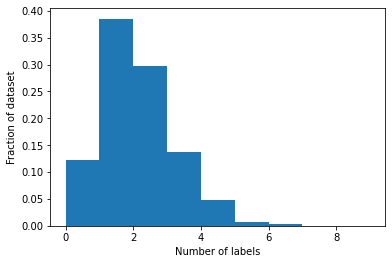

In [33]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()

plot_label_frequency(L_train)

ここでは、ラベル付け関数から得たラベルを、単一のラベルに変換します。そのために多数決を取ります。この多数決では、データをどのようにラベル付けすべきかについて決を取ります。たとえば、多くのラベル付け関数がデータをspamというのであれば、そのデータにspamラベルを付与します。

- [MajorityLabelVoter](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.model.baselines.MajorityLabelVoter.html?highlight=majority#snorkel.labeling.model.baselines.MajorityLabelVoter)

In [34]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [35]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

<!--However there may be functions that are correlated and might give a false sense of majority , to handle this we use a differernt snorkel label model to comine inputs of the labeling functions.-->

場合によっては、相関関係のある関数があり、誤った多数決となる可能性があります。このような場合には、SnorkelのLabelModelを用いて、ラベル付け関数の出力を組み合わせます。

LabelModelは、観測されていない真のラベルYを出力するラベル付け関数の条件付き確率*P(lf | Y)*のモデルを学習し、この学習したモデルを使って、出力ラベルの再重み付けと結合を行います。詳細については以下のドキュメントを参照してください。

- [LabelModel](https://snorkel.readthedocs.io/en/v0.9.7/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html)

In [36]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [37]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   84.0%
Label Model Accuracy:     86.4%


各データがスパムであるという確信度を確認するために、別のグラフをプロットします。

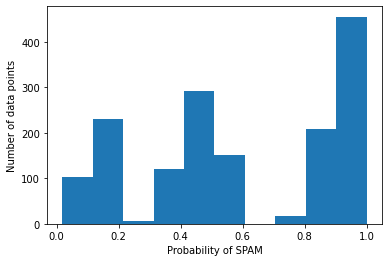

In [38]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

関数がラベルを付与していないデータがあるかもしれないので、以下のようにフィルタリングします。

In [39]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## 分類器の学習

ここでは、生成した確率的な学習ラベルを使って分類器を学習します。
注：分類器についてわかっていなくても心配しないでください。第4章ですべて説明しています。第4章を読んで、第4章のノートブックを見てください。

In [40]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [41]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [42]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 94.0%


ここで紹介したのはSnorkelのほんの一部に過ぎません。より詳しく知るためには、[GitHubリポジトリ](https://github.com/snorkel-team/snorkel)や[チュートリアル](https://github.com/snorkel-team/snorkel-tutorials)を参照してください。